### Load Libraries

In [1]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


##SKLearn for Machine Model Tools

from sklearn.model_selection import train_test_split # split  data into training and testing sets
from sklearn.model_selection import GridSearchCV # cross validation
from sklearn.metrics import confusion_matrix # creates a confusion matrix
from sklearn.metrics import plot_confusion_matrix # draws a confusion matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

from sklearn.svm import SVC

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
import xgboost as xgb # XGBoost stuff


### Create Function to inspect DataFrame at high Level

In [2]:
def dataframe_overview(df):
    print("DataFrame info:")
    print("--------------------")
    print(df.info())
    print("\nDescribe DataFrame:")
    print("---------------------------------------------")
    print(df.describe())
    print("\nCount(Distinct):")
    print("-------------------------")
    print(df.nunique())
    print(f"\nNumber of observations: {df.shape[0]}")
    print("\nData Types:")
    print("-----------")
    print(df.dtypes)
    ##titanic_df_train.isna().sum()
    print("\nIsNASum:")
    print("-----------")
    print(df.isna().sum())


# ML Step # 1: Problem Identification

### Problem Definition: Predicting Life or Death in the RMS Titanic
The Titanic was a luxury British steamship that sank on its maiden voyage after hitting an iceberg on April 1912. The ship had lifeboats, but not enough for everyone.
Among the 2240 total passengers 1517 perished. And although there was some element of luck in getting on a lifeboat, some groups were more likely to get on a lifeboat than others.
In this notebook we will try to create a model that determines whether or not someone was likely to survive using passenger data (ie name, age, gender, socio-economic class, etc) collected prior to embarking.


# ML Step # 2: Data Collection

### Load the Test and Training file Kaggle provides

In [3]:
titanic_df_train = pd.read_csv('train.csv')
titanic_df_test = pd.read_csv('test.csv')

##Combine the files to make Feature Engineering Easier

concatenated_df = pd.concat([titanic_df_train, titanic_df_test], ignore_index=True)

In [4]:
dataframe_overview(concatenated_df)

DataFrame info:
--------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB
None

Describe DataFrame:
---------------------------------------------
       PassengerId    Survived       Pclass          Age        SibSp  \
count  1309.000000  891.000000  1309.000000  1046.000000  1


# ML Step #3: Data Preparation, Feature Engineering
###### Variable by Variable


#### Ensuring Data Is Tidy
#### Handling Missing Data
#### Label Encoding
#### Transforming Continuous variables
#### Recoding Categorical Variables



#### Variable #1:  Name

From this variable we will extract the title.  For titles that are less common we label as "TitleOfRespect" as they follow this trend of having a title of status, due to occupation or birth.  

In [5]:
# Extracting Title from Name from it's postion in relation to delimitting comma, and period

concatenated_df['Title'] = concatenated_df['Name'].apply(lambda x: x.split(', ')[1].split('.')[0])

In [6]:
title_counts = concatenated_df['Title'].value_counts()

In [7]:
##Grouping the Infrequent Titles- All are titles of higher class, or achieved status

concatenated_df['Title'] = concatenated_df['Title'].apply(lambda x: x if title_counts[x] > 10 else 'TitleOfRespect')

#### Variable #2:  Gender

Made the field numeric

In [8]:
concatenated_df['Sex'] = concatenated_df.Sex.apply(lambda x: 0 if x == "female" else 1)

#### Variable #3:  Pclass

No transformation necessary

#### Variable #4:  Age

Imputed missing Age values by calculating median Age by Class.
Created Categorical Variable by what Age Group they were in.(Children Teens, Young Adults etc)


In [9]:
##Impute missing Age fields by assigning median Age for their Passenger Class

AgeByPclass = concatenated_df.groupby(['Pclass']).median('Age')['Age'].to_dict()

concatenated_df['Age'] = concatenated_df.apply(lambda x: x.Age if not pd.isna(x.Age) else AgeByPclass[x.Pclass],axis = 1)


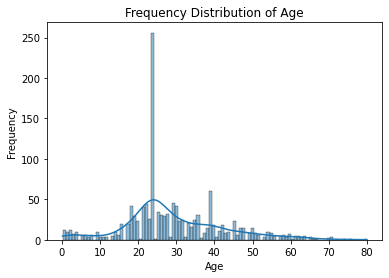

In [10]:


##concatenated_df[concatenated_df['Fare'] < 100]


sns.histplot(concatenated_df['Age'][concatenated_df['Age'] < 100], bins=100, kde=True)  # KDE line adds a density plot
plt.xlabel('Age')  # Replace with your column name
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Age')  # Replace with your column title
plt.show()

In [11]:
def bucketAges(value):
    if value < 13:
        return 'C'
    elif 13 <= value < 20:
        return 'T'
    elif  20 <= value < 35:
        return 'YA'
    elif  35 <= value < 50:
        return 'A'
    else:
        return 'E'

In [12]:
concatenated_df['AgeCategory'] = concatenated_df['Age'].apply(bucketAges)

#### Variable #5 and #6: Parch and Sibsp

These numbers represent the number of parents or children, and the number of siblings. By adding them the result is the number of family members they had on board

In [13]:
concatenated_df['FamilyOnBoard'] = concatenated_df['Parch'] + concatenated_df['SibSp']

#### Variable #7 Ticket

This variable was transformed to create several new variables.

TicketCount was created by using the number of passengers who have the same ticket code.
IsTicketAlone was used to denote whether or not the ticket was only attributed to a single passenger.
Higher Level Ticket Code Groups were created based on the Prefix of the ticket

In [14]:
ticket_count = concatenated_df['Ticket'].value_counts()

In [15]:
concatenated_df['isTicketAlone'] = concatenated_df['Ticket'].apply(lambda x: 0 if ticket_count[str(x)]<=1 else 1)

In [16]:
concatenated_df['CountOfTickets'] = concatenated_df['Ticket'].apply(lambda x: ticket_count[str(x)])

In [17]:
concatenated_df['TicketCode'] = concatenated_df['Ticket'].apply(lambda x: str(x[:1]))


In [18]:

Tsame = ['1', '2', '3', 'S', 'P', 'C', 'A']
Tlow = ['4','5','6','7','8','L','W' ]
# 1, 2, 3, S, P, C, A - Leave as is
# 4,5,6,7,8,L,W - Low Survival
# Rest - High Survival
def groupTicket(ticket):
    if ticket in Tsame:
        return ticket
    elif ticket in Tlow:
        return 'Lo'
    else:
        return 'Hi'

In [19]:
concatenated_df['TicketCodeShort'] = concatenated_df['TicketCode'].apply(lambda x: groupTicket(x))

#### Variable #8 Fare

Fare prices fall into certain price levels, which also coincide with percentiles, we just use that trend to bucket the Fares into groups

In [20]:
FareByPclass = concatenated_df.groupby(['Pclass']).median('Fare')['Fare'].to_dict()
FareByPclass

concatenated_df['Fare'] = concatenated_df.apply(lambda x: x.Fare if not pd.isna(x.Fare) else FareByPclass[x.Pclass],axis = 1)

In [21]:
Q1 = concatenated_df['Fare'].quantile(0.25)
Q2 = concatenated_df['Fare'].quantile(0.5)  # This is also the median
Q3 = concatenated_df['Fare'].quantile(0.75)

print(f"Q1 (25th percentile): {Q1}")
print(f"Median (50th percentile): {Q2}")
print(f"Q3 (75th percentile): {Q3}")

Q1 (25th percentile): 7.8958
Median (50th percentile): 14.4542
Q3 (75th percentile): 31.275


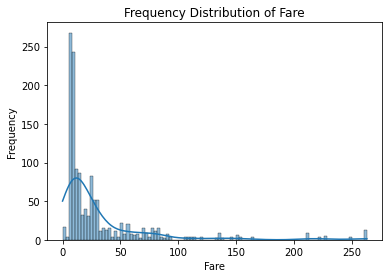

In [22]:


##concatenated_df[concatenated_df['Fare'] < 100]


sns.histplot(concatenated_df['Fare'][concatenated_df['Fare'] < 300], bins=100, kde=True)  # KDE line adds a density plot
plt.xlabel('Fare')  # Replace with your column name
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Fare')  # Replace with your column title
plt.show()

In [23]:
def MakeFareCategory(value):
    if value < 7.9:
        return 'V'
    elif 7.9 <= value < 14.5:
        return 'C'
    elif value < 31.275:
        return 'B'
    else:
        return 'A'

In [24]:
concatenated_df['FareCategory'] = concatenated_df['Fare'].apply(MakeFareCategory)

#### Variable #9 Cabin

 

In [25]:
concatenated_df['has_cabin'] = concatenated_df['Cabin'].apply(lambda x: 0 if pd.isna(x) else 1)
concatenated_df['Cabin'].fillna('Unknown',inplace=True)

In [26]:
concatenated_df['CabinCode'] = concatenated_df['Cabin'].apply(lambda x:str(x)[0])

In [27]:
def change_cabin_letter(pclass,cabin_code):
    if pclass == 1 and cabin_code == 'U':
        return 'C'
    elif pclass == 2 and cabin_code == 'U':
        return 'D'
    elif pclass == 3 and cabin_code == 'U':
        return 'G'
    elif cabin_code == 'T':
        return 'C'
    else:
        return cabin_code

In [28]:
concatenated_df['CabinCode'] = concatenated_df.apply(lambda x: change_cabin_letter(x.Pclass,x.CabinCode),axis=1)

In [29]:
# dropping unnecessary columns
if 'has_cabin' in concatenated_df.columns:
    concatenated_df = concatenated_df.drop(columns=['has_cabin'])
    
concatenated_df = concatenated_df.drop(columns = ['Cabin','Name'])

#### Variable #10 Embarked

In [30]:
embarked_mode = concatenated_df['Embarked'].mode()[0]
embarked_mode

'S'

In [31]:
concatenated_df['Embarked'].fillna(embarked_mode,inplace = True)

### Last Data Preparation Steps

Dropping unused variables
Creating Dummy variables
Scaling variables

Splitting up our Label, or variable that we are predicting, and the rest of our feature variables

### Split Tidy data into Dependent, Indepent Variables, Train and Test

In [49]:
##concatenated_df['Survived'] = concatenated_df['Survived'].astype(int)


ds_df = concatenated_df.drop(['PassengerId',
                              'SibSp', 'Parch', 'Ticket',  'TicketCode'], axis=1).copy() # alternatively: X = df_no_missing.iloc[:,:-1]


ds_df = pd.get_dummies(ds_df, columns=['Embarked', 'Title', 'TicketCodeShort', 'CabinCode', 'AgeCategory', 'FareCategory'])

X_train = ds_df[~ds_df['Survived'].isna()]
X_test = ds_df[ds_df['Survived'].isna()]
y_train = ds_df['Survived'][~ds_df['Survived'].isna()].astype(int)
X_train= X_train.drop(['Survived'], axis =1).copy()
X_test= X_test.drop(['Survived'], axis =1).copy()

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



# ML Step #4:  Model Selection

### XGBoost, ADABoost, Random Forest, SVM, Voting Classifer








# ML Step #5-7:  Model Training, Parameter Tuning, Model Evaluation

### XGBoost


In [33]:

## NOTE: This code takes a few minutes to run, so I've commented it out.
## Since I set seed=42, we'll get the same results anyway, and those are
## coded into the next section...

param_grid = {
    'max_depth': [3, 4, 5, 6, 7, 8],
    'n_estimators': range(50, 250, 50),
    'learning_rate': [0.1, 0.01, 0.05],
    'gamma': [0, 0.25, 0.5, 1.0],
    'reg_lambda': [0, 1.0, 10.0, 100.0],
    'random_state': [0]
}

optimal_params = GridSearchCV(
    estimator=xgb.XGBClassifier(objective='binary:logistic', eval_metric="logloss", seed=23, use_label_encoder=False),
    param_grid=param_grid,
    scoring = 'accuracy',
    verbose=2,
    n_jobs = 10,
    cv = 5
)

optimal_params.fit(X_train, y_train)
print(optimal_params.best_params_)



Fitting 5 folds for each of 1152 candidates, totalling 5760 fits
{'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200, 'random_state': 0, 'reg_lambda': 10.0}


In [34]:

best_model = optimal_params.best_estimator_

feature_importances = best_model.feature_importances_

# Print the feature importances
for i, v in enumerate(feature_importances):
    print(f'Feature: {i}, Score: {v:.5f}')

Feature: 0, Score: 0.01158
Feature: 1, Score: 0.02256
Feature: 2, Score: 0.01033
Feature: 3, Score: 0.00864
Feature: 4, Score: 0.00723
Feature: 5, Score: 0.00911
Feature: 6, Score: 0.02367
Feature: 7, Score: 0.01125
Feature: 8, Score: 0.00613
Feature: 9, Score: 0.01216
Feature: 10, Score: 0.00521
Feature: 11, Score: 0.00952
Feature: 12, Score: 0.43186
Feature: 13, Score: 0.00471
Feature: 14, Score: 0.10054
Feature: 15, Score: 0.03026
Feature: 16, Score: 0.00746
Feature: 17, Score: 0.00928
Feature: 18, Score: 0.00825
Feature: 19, Score: 0.00538
Feature: 20, Score: 0.00000
Feature: 21, Score: 0.00883
Feature: 22, Score: 0.01218
Feature: 23, Score: 0.01627
Feature: 24, Score: 0.00635
Feature: 25, Score: 0.00485
Feature: 26, Score: 0.00897
Feature: 27, Score: 0.00582
Feature: 28, Score: 0.03952
Feature: 29, Score: 0.00000
Feature: 30, Score: 0.12211
Feature: 31, Score: 0.00000
Feature: 32, Score: 0.00000
Feature: 33, Score: 0.00000
Feature: 34, Score: 0.00818
Feature: 35, Score: 0.00538
Fe

In [35]:
from sklearn.metrics import accuracy_score

# Get the best model
##best_model = optimal_params.best_estimator_

# Predict on the training data
train_predictions = best_model.predict(X_train)

# Calculate training accuracy
training_accuracy = accuracy_score(y_train, train_predictions)

# Print training accuracy
print("Training Accuracy:", training_accuracy)

Training Accuracy: 0.9023569023569024


In [36]:
#read sample submit file
sample_submit_file = pd.read_csv('gender_submission.csv')

# Predict on the training data
test_predictions = best_model.predict(X_test)

optim_xg_submitfile = sample_submit_file

In [37]:
##Code to create the submit file

optim_xg_submitfile = pd.concat([sample_submit_file['PassengerId'], pd.Series(test_predictions)], axis=1)
optim_xg_submitfile.rename(columns={optim_xg_submitfile.columns[1]: 'Survived'}, inplace=True)
optim_xg_submitfile.to_csv('result_optimizedxgboost.csv', index=False)

### ADABoost

In [38]:
from sklearn.ensemble import AdaBoostClassifier



clf_adaboost = AdaBoostClassifier(random_state=42)

# Define hyperparameter grid for AdaBoost
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'learning_rate': [0.001, 0.01, 0.1, 0.5, 1.0]
}

# GridSearchCV setup
grid_search = GridSearchCV(clf_adaboost, param_grid, cv=5, scoring='accuracy')

# Fit the model
grid_search.fit(X_train, y_train)

# Getting the best AdaBoost model from the grid search
clf_adaboost_optimized = grid_search.best_estimator_

# Print the best hyperparameters found by GridSearchCV
print("Best Hyperparameters for AdaBoost Classifier:")
print(grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

# Optionally, print the detailed classification report
best_ada = grid_search.best_estimator_
test_predictions = best_ada.predict(X_test)



test_predictions_str = test_predictions.astype(int).astype(str)

optim_ada_submitfile = pd.concat([sample_submit_file['PassengerId'], pd.Series(test_predictions_str)], axis=1)
optim_ada_submitfile.rename(columns={optim_ada_submitfile.columns[1]: 'Survived'}, inplace=True)


optim_ada_submitfile.to_csv('result_optim_ada.csv', index=False)




Best Hyperparameters for AdaBoost Classifier:
{'learning_rate': 1.0, 'n_estimators': 10}
Best score:  0.8305065595380077


### Random Forest

In [53]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_iris
from sklearn.metrics import classification_report


# Define the parameter grid, including the 'criterion' parameter



# Define the parameter grid, including the 'criterion' parameter
param_grid = {
    'criterion': ['gini', 'entropy'],  # Criterion for split quality
    'n_estimators': [10,25,50,100, 150, 200, 250, 300],   # Number of trees in the forest
    'max_depth': [None, 5,6,7,8,9,10, 13,15, 20,25, 30],   # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],   # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],     # Minimum number of samples required at a leaf node
    'bootstrap': [True, False]         # Whether bootstrap samples are used when building trees
}

# Initialize the classifier
rf = RandomForestClassifier()

# Initialize GridSearchCV with the classifier, parameter grid, and number of folds for cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print("Best parameters found: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

# Optionally, print the detailed classification report
best_rf = grid_search.best_estimator_
print("best Estimator: ", best_rf)





Fitting 3 folds for each of 3456 candidates, totalling 10368 fits
Best parameters found:  {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 25}
Best score:  0.8496071829405163
best Estimator:  RandomForestClassifier(criterion='entropy', max_depth=20, min_samples_split=10,
                       n_estimators=25)


In [54]:
test_predictions = best_rf.predict(X_test)

test_predictions_str = test_predictions.astype(int).astype(str)

##Code to create the submit file

optim_rf_submitfile = pd.concat([sample_submit_file['PassengerId'], pd.Series(test_predictions_str)], axis=1)
optim_rf_submitfile.rename(columns={optim_rf_submitfile.columns[1]: 'Survived'}, inplace=True)


optim_rf_submitfile.to_csv('result_optimized_rf.csv', index=False)

##  Testing Best Random Forest on Training Data

In [41]:
from sklearn.ensemble import RandomForestClassifier


from sklearn.metrics import classification_report



# Define the parameter grid, including the 'criterion' parameter
params = {
    'n_estimators': [250],
    'criterion': ['gini'],
    'max_depth': [9],
    ##'min_samples_split' : [10],
    'random_state': [888],
}

# Initialize the classifier
rf = RandomForestClassifier()

# Initialize GridSearchCV with the classifier, parameter grid, and number of folds for cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=params, cv=5, n_jobs=4, verbose=2)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print("Best parameters found: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

# Optionally, print the detailed classification report
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)





Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters found:  {'criterion': 'gini', 'max_depth': 9, 'n_estimators': 250, 'random_state': 888}
Best score:  0.8383968363567886


In [42]:
test_predictions = best_rf.predict(X_test)

test_predictions_str = test_predictions.astype(int).astype(str)

##Code to create the submit file

generalized_rf_submitfile = pd.concat([sample_submit_file['PassengerId'], pd.Series(test_predictions_str)], axis=1)
generalized_rf_submitfile.rename(columns={generalized_rf_submitfile.columns[1]: 'Survived'}, inplace=True)


generalized_rf_submitfile.to_csv('result_bestexp_rf.csv', index=False)

## Support Vector Machine

In [52]:

from sklearn.svm import SVC
# Initialize SVM
svm = SVC()

# Define hyperparameter options
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto'],
    'kernel': ['linear', 'rbf', 'poly']
}

# Create GridSearchCV object
grid_search = GridSearchCV(svm, param_grid, cv=5)

# Fit the model
grid_search.fit(X_train, y_train)

# Print best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Evaluate the model
# Print the best parameters and the corresponding score
print("Best parameters found: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)
print("Best estim: ", grid_search.best_estimator_)

best_svm = grid_search.best_estimator_
test_predictions = best_svm.predict(X_test)


test_predictions_str = test_predictions.astype(int).astype(str)
best_svm_submitfile = pd.concat([sample_submit_file['PassengerId'], pd.Series(test_predictions_str)], axis=1)
best_svm_submitfile.rename(columns={best_svm_submitfile.columns[1]: 'Survived'}, inplace=True)
best_svm_submitfile.to_csv('result_optim_svm.csv', index=False)

Best parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Best score: 0.8417362375243238
Best parameters found:  {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Best score:  0.8417362375243238
Best estim:  SVC(C=1, kernel='linear')


## Voting Classifier with Random Forest and XGBoost and ADABoost

In [50]:


rf_clf = RandomForestClassifier( random_state=888,
    n_estimators=250, criterion='gini', max_depth=9, 
    min_samples_split=10, min_samples_leaf=1, bootstrap=True

xgb_clf = xgb.XGBClassifier(learning_rate = .1, max_depth = 4,  n_estimators=200, random_state=0, reg_lambda = 10, objective='binary:logistic',
                            eval_metric="logloss", seed =23, use_label_encoder=False)


ab_clf = AdaBoostClassifier(n_estimators=10, learning_rate = 1, random_state=42)

# Train the individual classifiers
rf_clf.fit(X_train, y_train)

xgb_clf.fit(X_train, y_train)
ab_clf.fit(X_train, y_train)




voting_clf = VotingClassifier(
    estimators=[('rf', rf_clf), 
                ('xgb', xgb_clf),
                ('ab', ab_clf)],
    voting='soft'
)

# Train the VotingClassifier
voting_clf.fit(X_train, y_train)


# Make predictions
rf_pred = rf_clf.predict(X_test)
gb_pred = xgb_clf.predict(X_test)
ab_pred = ab_clf.predict(X_test)
##y_pred = voting_clf.predict(X_test)


test_predictions = voting_clf.predict(X_test)

test_predictions_str = test_predictions.astype(int).astype(str)
generalized_rf_submitfile = pd.concat([sample_submit_file['PassengerId'], pd.Series(test_predictions_str)], axis=1)
generalized_rf_submitfile.rename(columns={generalized_rf_submitfile.columns[1]: 'Survived'}, inplace=True)
generalized_rf_submitfile.to_csv('result_bigvoting_soft.csv', index=False)

## Voting Classifier with SVM and Random Forest

#### This is our final model that achieved 79.665%

In [51]:

# RandomForestClassifier instantiation
rf_model = RandomForestClassifier( random_state=888,
    n_estimators=250, criterion='gini', max_depth=9, 
    min_samples_split=10, min_samples_leaf=1, bootstrap=True
)


# SVC instantiation
svm_model = SVC(probability=True, random_state=42, C = 1, gamma = 'scale', kernel = 'linear')  # Enable probability estimation

##'C': 1, 'gamma': 'scale', 'kernel': 'linear'


# Create voting classifier with added SVM
voting_clf = VotingClassifier(
    estimators=[
        ('rf', rf_model),

        ('svm', svm_model)  # Add SVM model here
    ],
    voting='hard'  # Use 'soft' for probability-based voting
)

voting_clf.fit(X_train, y_train)


y_train_pred = voting_clf.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)

test_predictions = voting_clf.predict(X_test)

test_predictions_str = test_predictions.astype(int).astype(str)

generalized_rf_submitfile = pd.concat([sample_submit_file['PassengerId'], pd.Series(test_predictions_str)], axis=1)
generalized_rf_submitfile.rename(columns={generalized_rf_submitfile.columns[1]: 'Survived'}, inplace=True)


generalized_rf_submitfile.to_csv('FinalModel.csv', index=False)



In [ ]:
##Code to show how correlated the Random Forest and SVM Models are

# RandomForestClassifier instantiation
rf_model = RandomForestClassifier(random_state=888, n_estimators=250, criterion='gini', max_depth=9, 
                                  min_samples_split=10, min_samples_leaf=1, bootstrap=True)

# SVC instantiation
svm_model = SVC(probability=True, random_state=42, C=1, gamma='scale', kernel='linear')

# Fit both models separately
rf_model.fit(X_train, y_train)
svm_model.fit(X_train, y_train)

# Predict on test data
rf_predictions = rf_model.predict(X_test)
svm_predictions = svm_model.predict(X_test)

# Calculate the correlation between the two sets of predictions
correlation = np.corrcoef(rf_predictions, svm_predictions)[0, 1]

print(f"Correlation between RandomForest and SVM predictions: {correlation}")
